# Documentation

**Author:** Spencer Ressel

**Created:** December 10th, 2021

***
This script recreates Figures 1a and 1b from Ahmed 2021 using ERA5 column 
water vapor data. 
***

**Inputs:**     
* ERA5 Monthly Column Water Vapor (CWV) and Column-integrated Temperature (CIT) arrays
                
**Outputs:**
                
**Dependencies:**
* mjo_mean_state_diagnostics.ipynb

# Imports

In [3]:
# Data analysis
import os
os.chdir(f"/home/disk/eos7/sressel/research/thesis-work/python/mjo_data_analysis/")
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.colors as mcolor
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable
import seaborn as sns

# Cartopy
import cartopy.crs as ccrs
from cartopy import feature as cfeature
from cartopy import util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo

# Constants

In [4]:
#%% Constants
# Physical Constants
METERS_PER_DEGREE = 110.574 * 1e3
DENSITY_WATER = 997
GRAVITY = 9.8
LATENT_HEAT = 2.26 * 10 ** 6
SPECIFIC_HEAT_DRY_AIR = 1004
GROSS_DRY_STABILITY = 3.12e4

# Related to vertical structures
DELTA_PRESSURE = 999 * 1e2
INTEGRATED_MOISTURE_STRUCTURE = 54.6
INTEGRATED_VELOCITY_STRUCTURE = -0.35531135531135527

# sigma_y value from Ahmed 2021
A21_MERIDIONAL_MOISTURE_PARAMETER = 9e-9

# Load Data

In [5]:
# %% Load Data & Pre-process
# Load and process the data
data_directory = r"/home/disk/eos7/sressel/research/data/ECMWF/ERA5/"
file_name = r"monthly_reanalysis_CWV_CIT_2002_2014.nc"

# DataArray
data = xr.open_dataset(data_directory + file_name, engine="netcdf4")
data = data.reindex(latitude=list(reversed(data.latitude)))
data = data.rename({"p54.162": "column temperature"})

# Coordinates
time = data["time"]
latitude = data["latitude"]
longitude = data["longitude"]

# Total Column Water Vapour
column_water_vapor = data["tcwv"]
column_water_vapor = 1000 * (
    column_water_vapor / DENSITY_WATER
)  # Convert from kg/m^2 to mm
column_water_vapor.attrs["units"] = 'mm'

# Column-Integrated Temperature
total_column_temperature = data["column temperature"]

# Calculate averages

In [6]:
# Average Column Temperature
average_column_temperature = total_column_temperature / (
    DELTA_PRESSURE / GRAVITY
)  # Convert from K kg m^-2 to K

# Time Mean Column Water Vapor
time_mean_column_water_vapor_global = column_water_vapor.mean(dim="time")
time_mean_column_water_vapor_anomalies = (
    time_mean_column_water_vapor_global
    - time_mean_column_water_vapor_global.mean(dim=["latitude", "longitude"])
)

# Time Mean Average Column Temperature
time_mean_column_temperature = average_column_temperature.mean(dim="time")
time_mean_column_temperature_anomalies = (
    time_mean_column_temperature - time_mean_column_temperature.mean()
)

# Plot time mean CWV & CIT

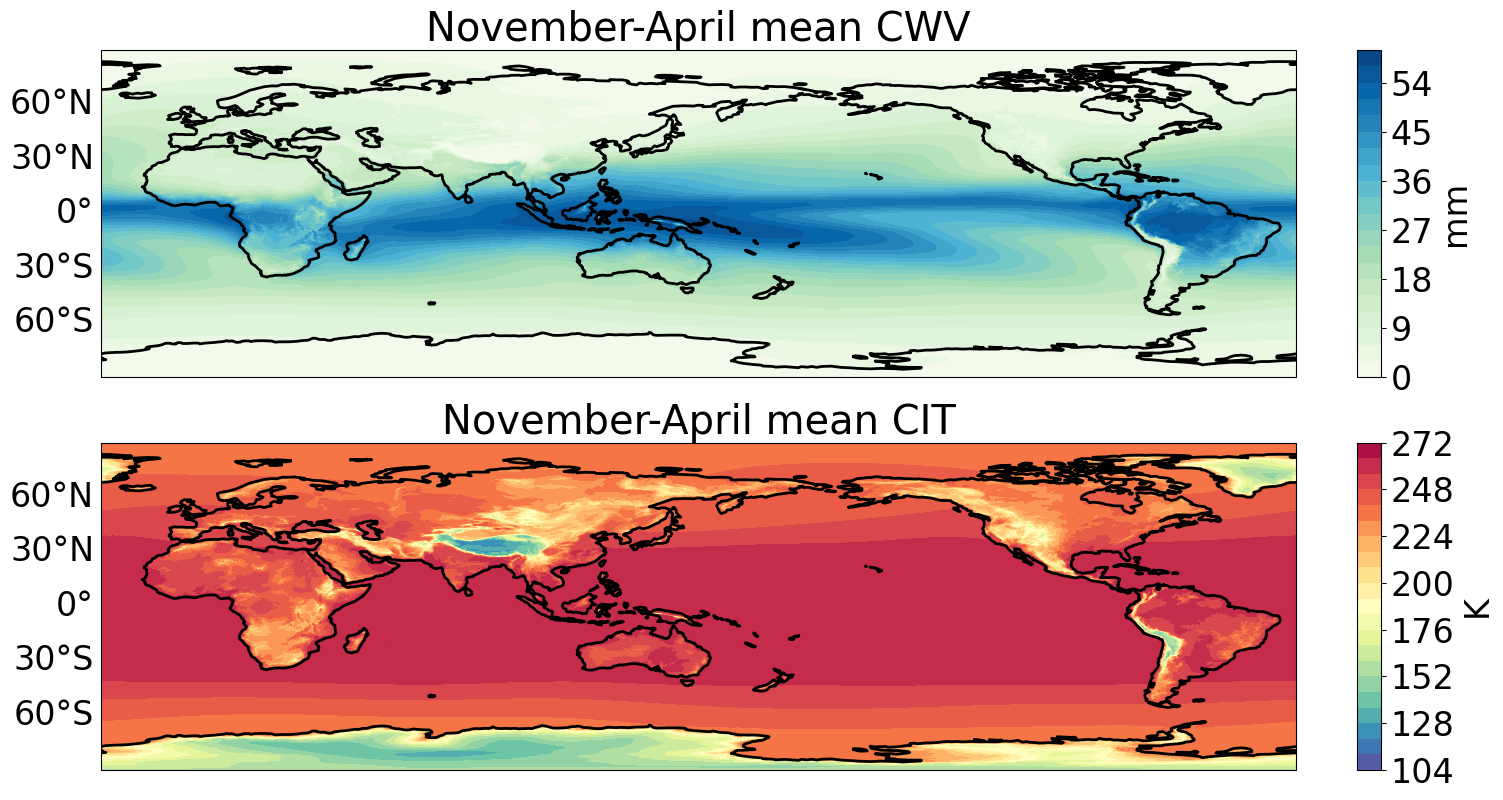

In [7]:
# Set plotting parameters
output_directory = r"output/"
plt.style.use('default')
plt.rcParams.update({"font.size": 24})

fig = plt.figure(figsize=(16,9))
gs = GridSpec(2, 2, figure=fig, width_ratios = [100, 2])
gs.update(left = 0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.2)

data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree(central_longitude=-210)

ax0 = fig.add_subplot(gs[0,0], projection=proj)
cbar_ax0 = fig.add_subplot(gs[0,1])

# Specify colormap
column_water_vapor_colormap = sns.color_palette("GnBu", as_cmap=True)

# Plot the CWV data as a function of longitude and latitude

cdata, clon = cutil.add_cyclic_point(
    time_mean_column_water_vapor_global,
    coord=time_mean_column_water_vapor_global.longitude
)

im = ax0.contourf(
    clon,
    time_mean_column_water_vapor_global.latitude,
    cdata,
    transform=data_crs,
    cmap=column_water_vapor_colormap,
    levels=21,
)
ax0.set_title("November-April mean CWV")

# Create a colorbar
cbar = fig.colorbar(im, cax=cbar_ax0)
cbar.set_label("mm")

# Add the land overlay
# ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
gl = ax0.gridlines(
    crs=proj,
    draw_labels=True,
    linewidth=2,
    color="black",
    alpha=0.0,
    linestyle="-",
)
gl.right_labels = False
gl.top_labels = False
ax0.add_feature(cfeature.COASTLINE, lw=2)
ax0.set_aspect('auto')


# Column Temperature
ax1 = fig.add_subplot(gs[1,0], projection=proj)
cbar_ax1 = fig.add_subplot(gs[1,1])

# Specify colormap
column_water_vapor_colormap = sns.color_palette("GnBu", as_cmap=True)

# Plot the CWV data as a function of longitude and latitude

cdata, clon = cutil.add_cyclic_point(
    time_mean_column_temperature,
    coord=time_mean_column_temperature.longitude
)

im = ax1.contourf(
    clon,
    time_mean_column_temperature.latitude,
    cdata,
    transform=data_crs,
    cmap='Spectral_r',
    levels=21,
)
ax1.set_title("November-April mean CIT")

# Create a colorbar
cbar = fig.colorbar(im, cax=cbar_ax1)
cbar.set_label("K")

# Add the land overlay
# ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
gl = ax1.gridlines(
    crs=proj,
    draw_labels=True,
    linewidth=2,
    color="black",
    alpha=0.0,
    linestyle="-",
)
gl.right_labels = False
gl.top_labels = False
ax1.add_feature(cfeature.COASTLINE, lw=2)
ax1.set_aspect('auto')

# # Plot it
# plt.show()
plt.savefig(f"{output_directory}ERA5_winter_mean_CWV_CIT.png", dpi=300, bbox_inches='tight')

# Parabolic Fit Function

In [8]:
# %% Parabolic Fits
def parabolic_fit_function(
    meridional_distance, zonal_time_mean_column_water_vapor, evaluation_points
):
    """
    Fit a meridionally-centered parabola to a zonally and time averaged 
    column water vapor field.

    Parameters
    ----------
    meridional_distance : xarray.core.dataarray.DataArray
        Array containing the physical distance (in m) from the equator of each 
        latitude point.
    zonal_time_mean_column_water_vapor : dict
        Dictionary containing gridded zonal and time mean CWV values for 
        each specified region.
    evaluation_points : numpy.ndarray
        Array containing the physical distances from the equator (in m) at 
        which to evaluate the parabolic fit.

    Returns
    -------
    parabolic_fit : dict
        Dictionary containing values of a best-fit parabola for each specified
        region.
    shifted_evaluation_points : dict
        Dictionary containing distance from the equator (in m) locations 
        corresponding to the best-fit parabolas, shifted to be centered 
        around the equator, for each specified region.
    meridional_moisture_gradient_parameter : dict
        Dictionary containing values for the parameter 
        σ_y (as defined in Ahmed 2021), corresponding to each specified 
        region. 

    """

    # Calculate the coefficients specifying the parabolic fit
    parabolic_fit_coefficients = np.polyfit(
        meridional_distance,
        zonal_time_mean_column_water_vapor / INTEGRATED_MOISTURE_STRUCTURE,
        2,
    )

    # Evaluate the parabolic fit on the chosen domain
    parabolic_fit = INTEGRATED_MOISTURE_STRUCTURE * np.polyval(
        parabolic_fit_coefficients, evaluation_points
    )

    # Shift the evaluation points so that the parabolic fit is centered at the equator
    shifted_evaluation_points = (
        evaluation_points - evaluation_points[np.argmax(parabolic_fit)]
    )

    # Calculate the strength of the basic state meridional moisture gradient
    meridional_moisture_gradient_strength = 2 * parabolic_fit_coefficients[0]

    # Convert to match σ_y from Ahmed 2021 with units K kg m^-4
    meridional_moisture_gradient_parameter = (
        meridional_moisture_gradient_strength
        * (LATENT_HEAT / SPECIFIC_HEAT_DRY_AIR)
        * INTEGRATED_MOISTURE_STRUCTURE
        * INTEGRATED_VELOCITY_STRUCTURE
    )

    return (
        parabolic_fit,
        shifted_evaluation_points,
        meridional_moisture_gradient_parameter,
    )

# Plot time mean and time-zonal mean CWV

## Warm Pool

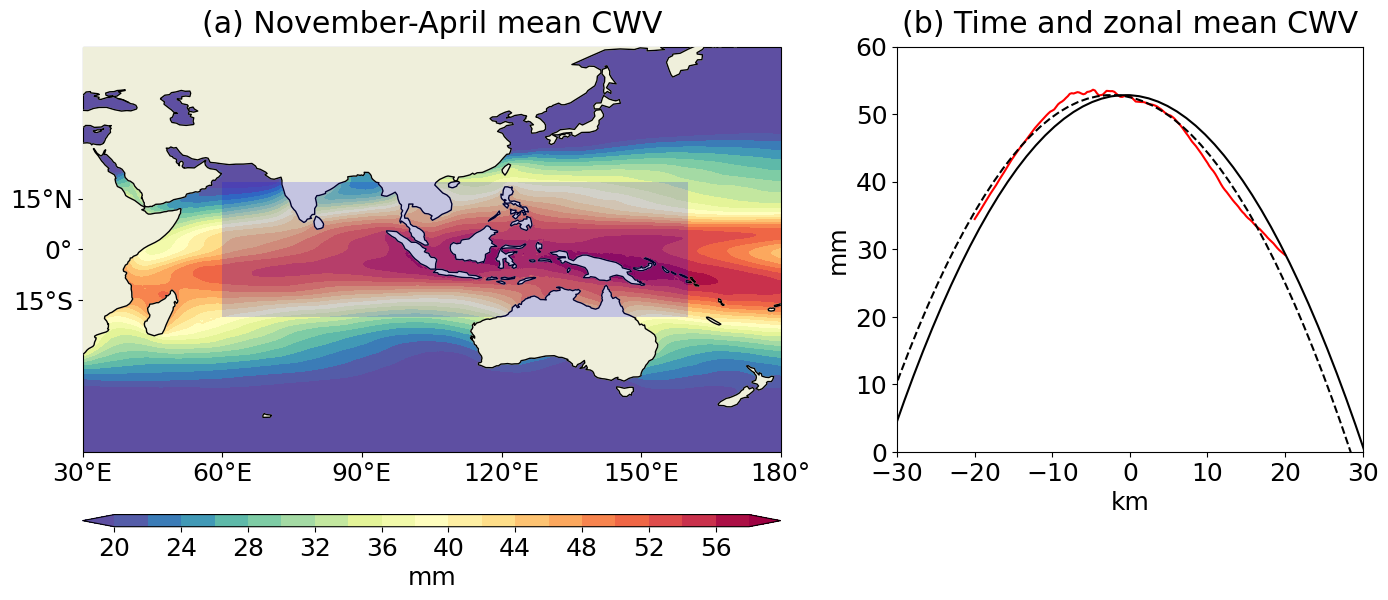

In [15]:
output_directory = r"output/Ahmed21/"

avg_lons = [60,160]
avg_lats = [-20,20]

time_zonal_mean_column_water_vapor = column_water_vapor.sel(
    latitude=slice(avg_lats[0],avg_lats[1]), 
    longitude=slice(avg_lons[0], avg_lons[1])
).mean(dim=['longitude','time'])


plt.style.use('default')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(16,6))
gs = GridSpec(2,2, figure=fig, width_ratios=[60,40], height_ratios = [100, 3])
gs.update(left = 0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree()

map_ax0 = fig.add_subplot(gs[0,0], projection=proj)
cbar_ax0 = fig.add_subplot(gs[1,0])
plot_ax0 = fig.add_subplot(gs[0,1])

map_ax0.set_title('(a) November-April mean CWV', pad=10)
cont = map_ax0.contourf(
    column_water_vapor.longitude,
    column_water_vapor.latitude,
    column_water_vapor.mean(dim='time'),
    transform=data_crs,
    cmap='Spectral_r',
    levels=np.arange(20,60,2),
    extend='both'
)

# map_ax0.set_extent([30,180,-30,30], crs=proj)
map_ax0.set_extent([30,180,-60,60], crs=proj)
map_ax0.set_aspect('auto')

cbar = fig.colorbar(cont, cax=cbar_ax0, orientation='horizontal')
cbar.set_label('mm')
cbar.set_ticks(np.arange(20,60,4))

map_ax0.set_xticks(np.arange(30,210,30), crs=proj)
map_ax0.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

map_ax0.set_yticks(np.arange(-15,30,15), crs=proj)
map_ax0.yaxis.set_major_formatter(LatitudeFormatter())

map_ax0.add_feature(cfeature.LAND, zorder=100)
map_ax0.add_feature(cfeature.COASTLINE, lw=1, zorder=101)

map_ax0.spines['left'].set_edgecolor('black')
map_ax0.spines['right'].set_edgecolor('black')
map_ax0.spines['top'].set_edgecolor('black')
map_ax0.spines['bottom'].set_edgecolor('black')

rectangle = mpatches.Rectangle(
    (avg_lons[0], avg_lats[0]),
    avg_lons[1] - avg_lons[0],
    avg_lats[1]-avg_lats[0],
    facecolor='blue',
    alpha=0.175,
    zorder=102,
    transform=data_crs
)
map_ax0.add_patch(rectangle)

# Time and zonal mean CWV 
# evaluation_points = np.linspace(-24, 19, 100)
evaluation_points = np.linspace(-60, 60, 100)
parabolic_fit_coefficients = np.polyfit(
        time_zonal_mean_column_water_vapor.latitude,
        time_zonal_mean_column_water_vapor,
        2,
    )

# Evaluate the parabolic fit on the chosen domain
parabolic_fit = np.polyval(
        parabolic_fit_coefficients, evaluation_points
    )


plot_ax0.set_title('(b) Time and zonal mean CWV', pad=10)
plot_ax0.plot(
    time_zonal_mean_column_water_vapor.latitude,
    time_zonal_mean_column_water_vapor,
    color='red',
    label='ERA5'
)

plot_ax0.plot(
    evaluation_points,
    parabolic_fit,
    color='black',
    ls='--',
    label='Shifted'
)

plot_ax0.plot(
    evaluation_points-evaluation_points[np.argmax(parabolic_fit)],
    parabolic_fit,
    color='black',
    label='Idealized'
)

# plot_ax0.set_ylim(25,55)
plot_ax0.set_ylim(0,60)
plot_ax0.set_ylabel('mm')

plot_ax0.set_xlim(-30, 30)
# plot_ax0.set_xticks([-7000*(1000/METERS_PER_DEGREE), 0, 7000*(1000/METERS_PER_DEGREE)])
# plot_ax0.set_xticklabels([-7000, 0, 7000])
plot_ax0.set_xlabel('km')

plot_ax0.set_aspect('auto')
plt.show()

# plt.savefig(f"{output_directory}/Ahmed21_Fig1.png", dpi=300, bbox_inches='tight')

## Indian Ocean 

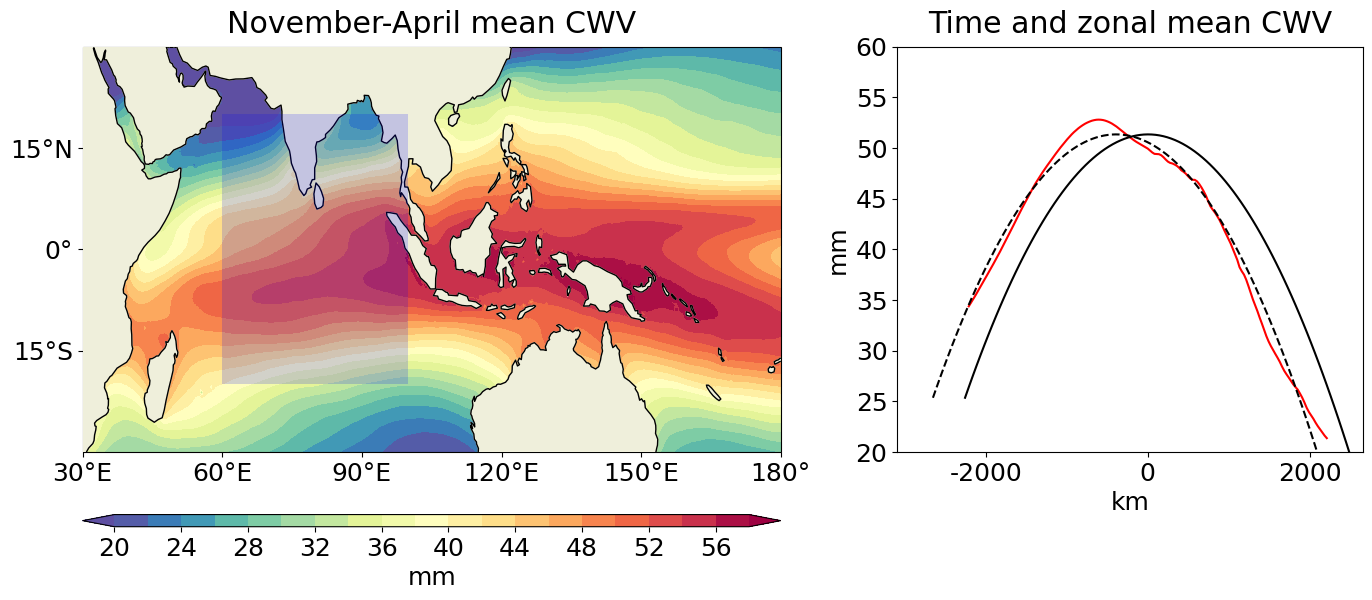

In [10]:
output_directory = r"output/Ahmed21/"

avg_lons = [60,100]
avg_lats = [-20,20]

time_zonal_mean_column_water_vapor = column_water_vapor.sel(
    latitude=slice(avg_lats[0],avg_lats[1]), 
    longitude=slice(avg_lons[0], avg_lons[1])
).mean(dim=['longitude','time'])


plt.style.use('default')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(16,6))
gs = GridSpec(2,2, figure=fig, width_ratios=[60,40], height_ratios = [100, 3])
gs.update(left = 0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree()

map_ax0 = fig.add_subplot(gs[0,0], projection=proj)
cbar_ax0 = fig.add_subplot(gs[1,0])
plot_ax0 = fig.add_subplot(gs[0,1])

map_ax0.set_title('November-April mean CWV', pad=10)
cont = map_ax0.contourf(
    column_water_vapor.longitude,
    column_water_vapor.latitude,
    column_water_vapor.mean(dim='time'),
    transform=data_crs,
    cmap='Spectral_r',
    levels=np.arange(20,60,2),
    extend='both'
)

map_ax0.set_extent([30,180,-30,30], crs=proj)
map_ax0.set_aspect('auto')

cbar = fig.colorbar(cont, cax=cbar_ax0, orientation='horizontal')
cbar.set_label('mm')
cbar.set_ticks(np.arange(20,60,4))

map_ax0.set_xticks(np.arange(30,210,30), crs=proj)
map_ax0.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

map_ax0.set_yticks(np.arange(-15,30,15), crs=proj)
map_ax0.yaxis.set_major_formatter(LatitudeFormatter())

map_ax0.add_feature(cfeature.LAND, zorder=100)
map_ax0.add_feature(cfeature.COASTLINE, lw=1, zorder=101)

map_ax0.spines['left'].set_edgecolor('black')
map_ax0.spines['right'].set_edgecolor('black')
map_ax0.spines['top'].set_edgecolor('black')
map_ax0.spines['bottom'].set_edgecolor('black')

rectangle = mpatches.Rectangle(
    (avg_lons[0], avg_lats[0]),
    avg_lons[1] - avg_lons[0],
    avg_lats[1]-avg_lats[0],
    facecolor='blue',
    alpha=0.175,
    zorder=102,
    transform=data_crs
)
map_ax0.add_patch(rectangle)

# Time and zonal mean CWV 
evaluation_points = np.linspace(-24, 19, 100)
parabolic_fit_coefficients = np.polyfit(
        time_zonal_mean_column_water_vapor.latitude,
        time_zonal_mean_column_water_vapor,
        2,
    )

# Evaluate the parabolic fit on the chosen domain
parabolic_fit = np.polyval(
        parabolic_fit_coefficients, evaluation_points
    )


plot_ax0.set_title('Time and zonal mean CWV', pad=10)
plot_ax0.plot(
    time_zonal_mean_column_water_vapor.latitude,
    time_zonal_mean_column_water_vapor,
    color='red',
    label='ERA5'
)

plot_ax0.plot(
    evaluation_points,
    parabolic_fit,
    color='black',
    ls='--',
    label='Shifted'
)

plot_ax0.plot(
    evaluation_points-evaluation_points[np.argmax(parabolic_fit)],
    parabolic_fit,
    color='black',
    label='Idealized'
)

plot_ax0.set_ylim(20,60)
plot_ax0.set_ylabel('mm')

plot_ax0.set_xlim(-28, 24)
plot_ax0.set_xticks([-2000*(1000/METERS_PER_DEGREE), 0, 2000*(1000/METERS_PER_DEGREE)])
plot_ax0.set_xticklabels([-2000, 0, 2000])
plot_ax0.set_xlabel('km')

plot_ax0.set_aspect('auto')
plt.savefig(f"{output_directory}/Ahmed21_Fig1_modified_IO.png", dpi=300, bbox_inches='tight')

## Maritime Continent

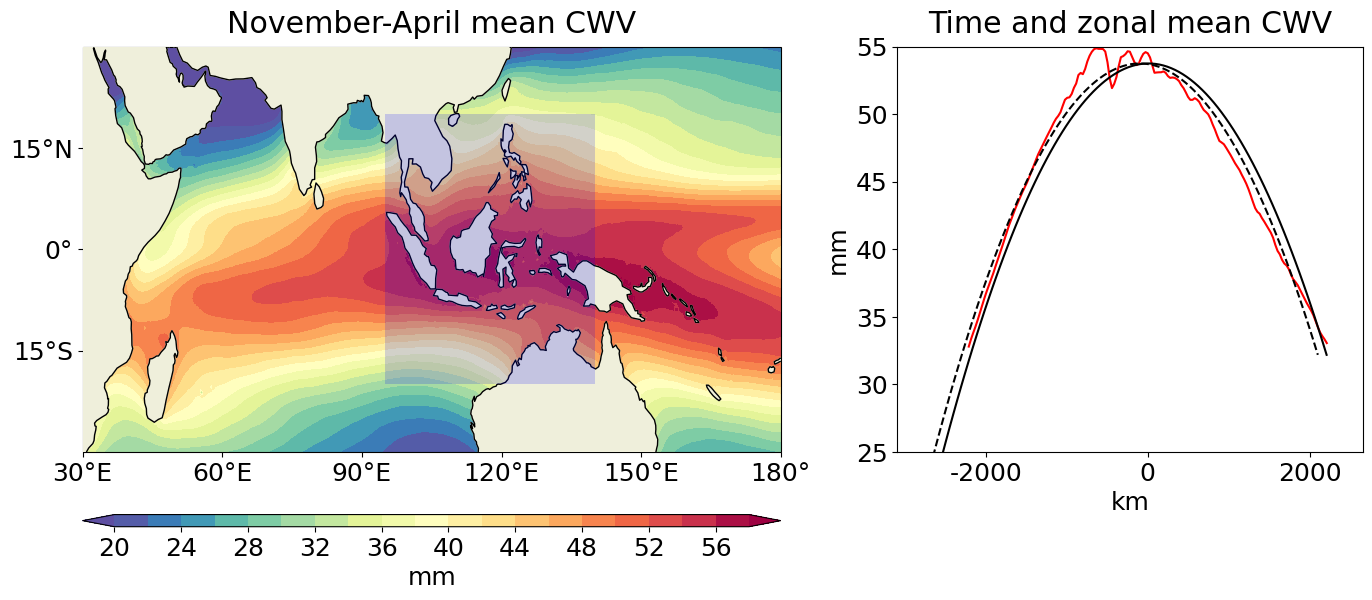

In [12]:
output_directory = r"output/Ahmed21/"

avg_lons = [95,140]
avg_lats = [-20,20]

time_zonal_mean_column_water_vapor = column_water_vapor.sel(
    latitude=slice(avg_lats[0],avg_lats[1]), 
    longitude=slice(avg_lons[0], avg_lons[1])
).mean(dim=['longitude','time'])


plt.style.use('default')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(16,6))
gs = GridSpec(2,2, figure=fig, width_ratios=[60,40], height_ratios = [100, 3])
gs.update(left = 0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree()

map_ax0 = fig.add_subplot(gs[0,0], projection=proj)
cbar_ax0 = fig.add_subplot(gs[1,0])
plot_ax0 = fig.add_subplot(gs[0,1])

map_ax0.set_title('November-April mean CWV', pad=10)
cont = map_ax0.contourf(
    column_water_vapor.longitude,
    column_water_vapor.latitude,
    column_water_vapor.mean(dim='time'),
    transform=data_crs,
    cmap='Spectral_r',
    levels=np.arange(20,60,2),
    extend='both'
)

map_ax0.set_extent([30,180,-30,30], crs=proj)
map_ax0.set_aspect('auto')

cbar = fig.colorbar(cont, cax=cbar_ax0, orientation='horizontal')
cbar.set_label('mm')
cbar.set_ticks(np.arange(20,60,4))

map_ax0.set_xticks(np.arange(30,210,30), crs=proj)
map_ax0.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

map_ax0.set_yticks(np.arange(-15,30,15), crs=proj)
map_ax0.yaxis.set_major_formatter(LatitudeFormatter())

map_ax0.add_feature(cfeature.LAND, zorder=100)
map_ax0.add_feature(cfeature.COASTLINE, lw=1, zorder=101)

map_ax0.spines['left'].set_edgecolor('black')
map_ax0.spines['right'].set_edgecolor('black')
map_ax0.spines['top'].set_edgecolor('black')
map_ax0.spines['bottom'].set_edgecolor('black')

rectangle = mpatches.Rectangle(
    (avg_lons[0], avg_lats[0]),
    avg_lons[1] - avg_lons[0],
    avg_lats[1]-avg_lats[0],
    facecolor='blue',
    alpha=0.175,
    zorder=102,
    transform=data_crs
)
map_ax0.add_patch(rectangle)

# Time and zonal mean CWV 
evaluation_points = np.linspace(-24, 19, 100)
parabolic_fit_coefficients = np.polyfit(
        time_zonal_mean_column_water_vapor.latitude,
        time_zonal_mean_column_water_vapor,
        2,
    )

# Evaluate the parabolic fit on the chosen domain
parabolic_fit = np.polyval(
        parabolic_fit_coefficients, evaluation_points
    )


plot_ax0.set_title('Time and zonal mean CWV', pad=10)
plot_ax0.plot(
    time_zonal_mean_column_water_vapor.latitude,
    time_zonal_mean_column_water_vapor,
    color='red',
    label='ERA5'
)

plot_ax0.plot(
    evaluation_points,
    parabolic_fit,
    color='black',
    ls='--',
    label='Shifted'
)

plot_ax0.plot(
    evaluation_points-evaluation_points[np.argmax(parabolic_fit)],
    parabolic_fit,
    color='black',
    label='Idealized'
)

plot_ax0.set_ylim(25,55)
plot_ax0.set_ylabel('mm')

plot_ax0.set_xlim(-28, 24)
plot_ax0.set_xticks([-2000*(1000/METERS_PER_DEGREE), 0, 2000*(1000/METERS_PER_DEGREE)])
plot_ax0.set_xticklabels([-2000, 0, 2000])
plot_ax0.set_xlabel('km')

plot_ax0.set_aspect('auto')
plt.savefig(f"{output_directory}/Ahmed21_Fig1_modified_MC.png", dpi=300, bbox_inches='tight')

## Western Pacific

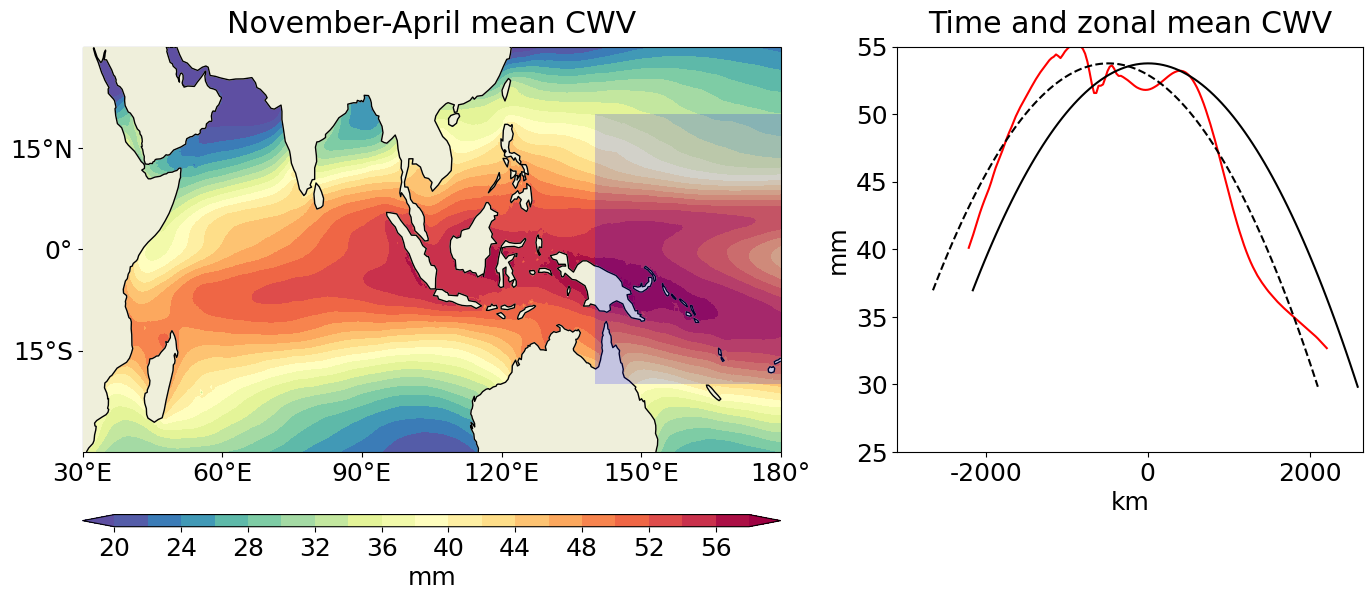

In [11]:
avg_lons = [140,180]
avg_lats = [-20,20]

time_zonal_mean_column_water_vapor = column_water_vapor.sel(
    latitude=slice(avg_lats[0],avg_lats[1]), 
    longitude=slice(avg_lons[0], avg_lons[1])
).mean(dim=['longitude','time'])


plt.style.use('default')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(16,6))
gs = GridSpec(2,2, figure=fig, width_ratios=[60,40], height_ratios = [100, 3])
gs.update(left = 0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree()

map_ax0 = fig.add_subplot(gs[0,0], projection=proj)
cbar_ax0 = fig.add_subplot(gs[1,0])
plot_ax0 = fig.add_subplot(gs[0,1])

map_ax0.set_title('November-April mean CWV', pad=10)
cont = map_ax0.contourf(
    column_water_vapor.longitude,
    column_water_vapor.latitude,
    column_water_vapor.mean(dim='time'),
    transform=data_crs,
    cmap='Spectral_r',
    levels=np.arange(20,60,2),
    extend='both'
)

map_ax0.set_extent([30,180,-30,30], crs=proj)
map_ax0.set_aspect('auto')

cbar = fig.colorbar(cont, cax=cbar_ax0, orientation='horizontal')
cbar.set_label('mm')
cbar.set_ticks(np.arange(20,60,4))

map_ax0.set_xticks(np.arange(30,210,30), crs=proj)
map_ax0.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

map_ax0.set_yticks(np.arange(-15,30,15), crs=proj)
map_ax0.yaxis.set_major_formatter(LatitudeFormatter())

map_ax0.add_feature(cfeature.LAND, zorder=100)
map_ax0.add_feature(cfeature.COASTLINE, lw=1, zorder=101)

map_ax0.spines['left'].set_edgecolor('black')
map_ax0.spines['right'].set_edgecolor('black')
map_ax0.spines['top'].set_edgecolor('black')
map_ax0.spines['bottom'].set_edgecolor('black')

rectangle = mpatches.Rectangle(
    (avg_lons[0], avg_lats[0]),
    avg_lons[1] - avg_lons[0],
    avg_lats[1]-avg_lats[0],
    facecolor='blue',
    alpha=0.175,
    zorder=102,
    transform=data_crs
)
map_ax0.add_patch(rectangle)

# Time and zonal mean CWV 
evaluation_points = np.linspace(-24, 19, 100)
parabolic_fit_coefficients = np.polyfit(
        time_zonal_mean_column_water_vapor.latitude,
        time_zonal_mean_column_water_vapor,
        2,
    )

# Evaluate the parabolic fit on the chosen domain
parabolic_fit = np.polyval(
        parabolic_fit_coefficients, evaluation_points
    )


plot_ax0.set_title('Time and zonal mean CWV', pad=10)
plot_ax0.plot(
    time_zonal_mean_column_water_vapor.latitude,
    time_zonal_mean_column_water_vapor,
    color='red',
    label='ERA5'
)

plot_ax0.plot(
    evaluation_points,
    parabolic_fit,
    color='black',
    ls='--',
    label='Shifted'
)

plot_ax0.plot(
    evaluation_points-evaluation_points[np.argmax(parabolic_fit)],
    parabolic_fit,
    color='black',
    label='Idealized'
)

plot_ax0.set_ylim(25,55)
plot_ax0.set_ylabel('mm')

plot_ax0.set_xlim(-28, 24)
plot_ax0.set_xticks([-2000*(1000/METERS_PER_DEGREE), 0, 2000*(1000/METERS_PER_DEGREE)])
plot_ax0.set_xticklabels([-2000, 0, 2000])
plot_ax0.set_xlabel('km')

plot_ax0.set_aspect('auto')
plt.savefig(f"{output_directory}/Ahmed21_Fig1_modified_WP.png", dpi=300, bbox_inches='tight')

## All regions

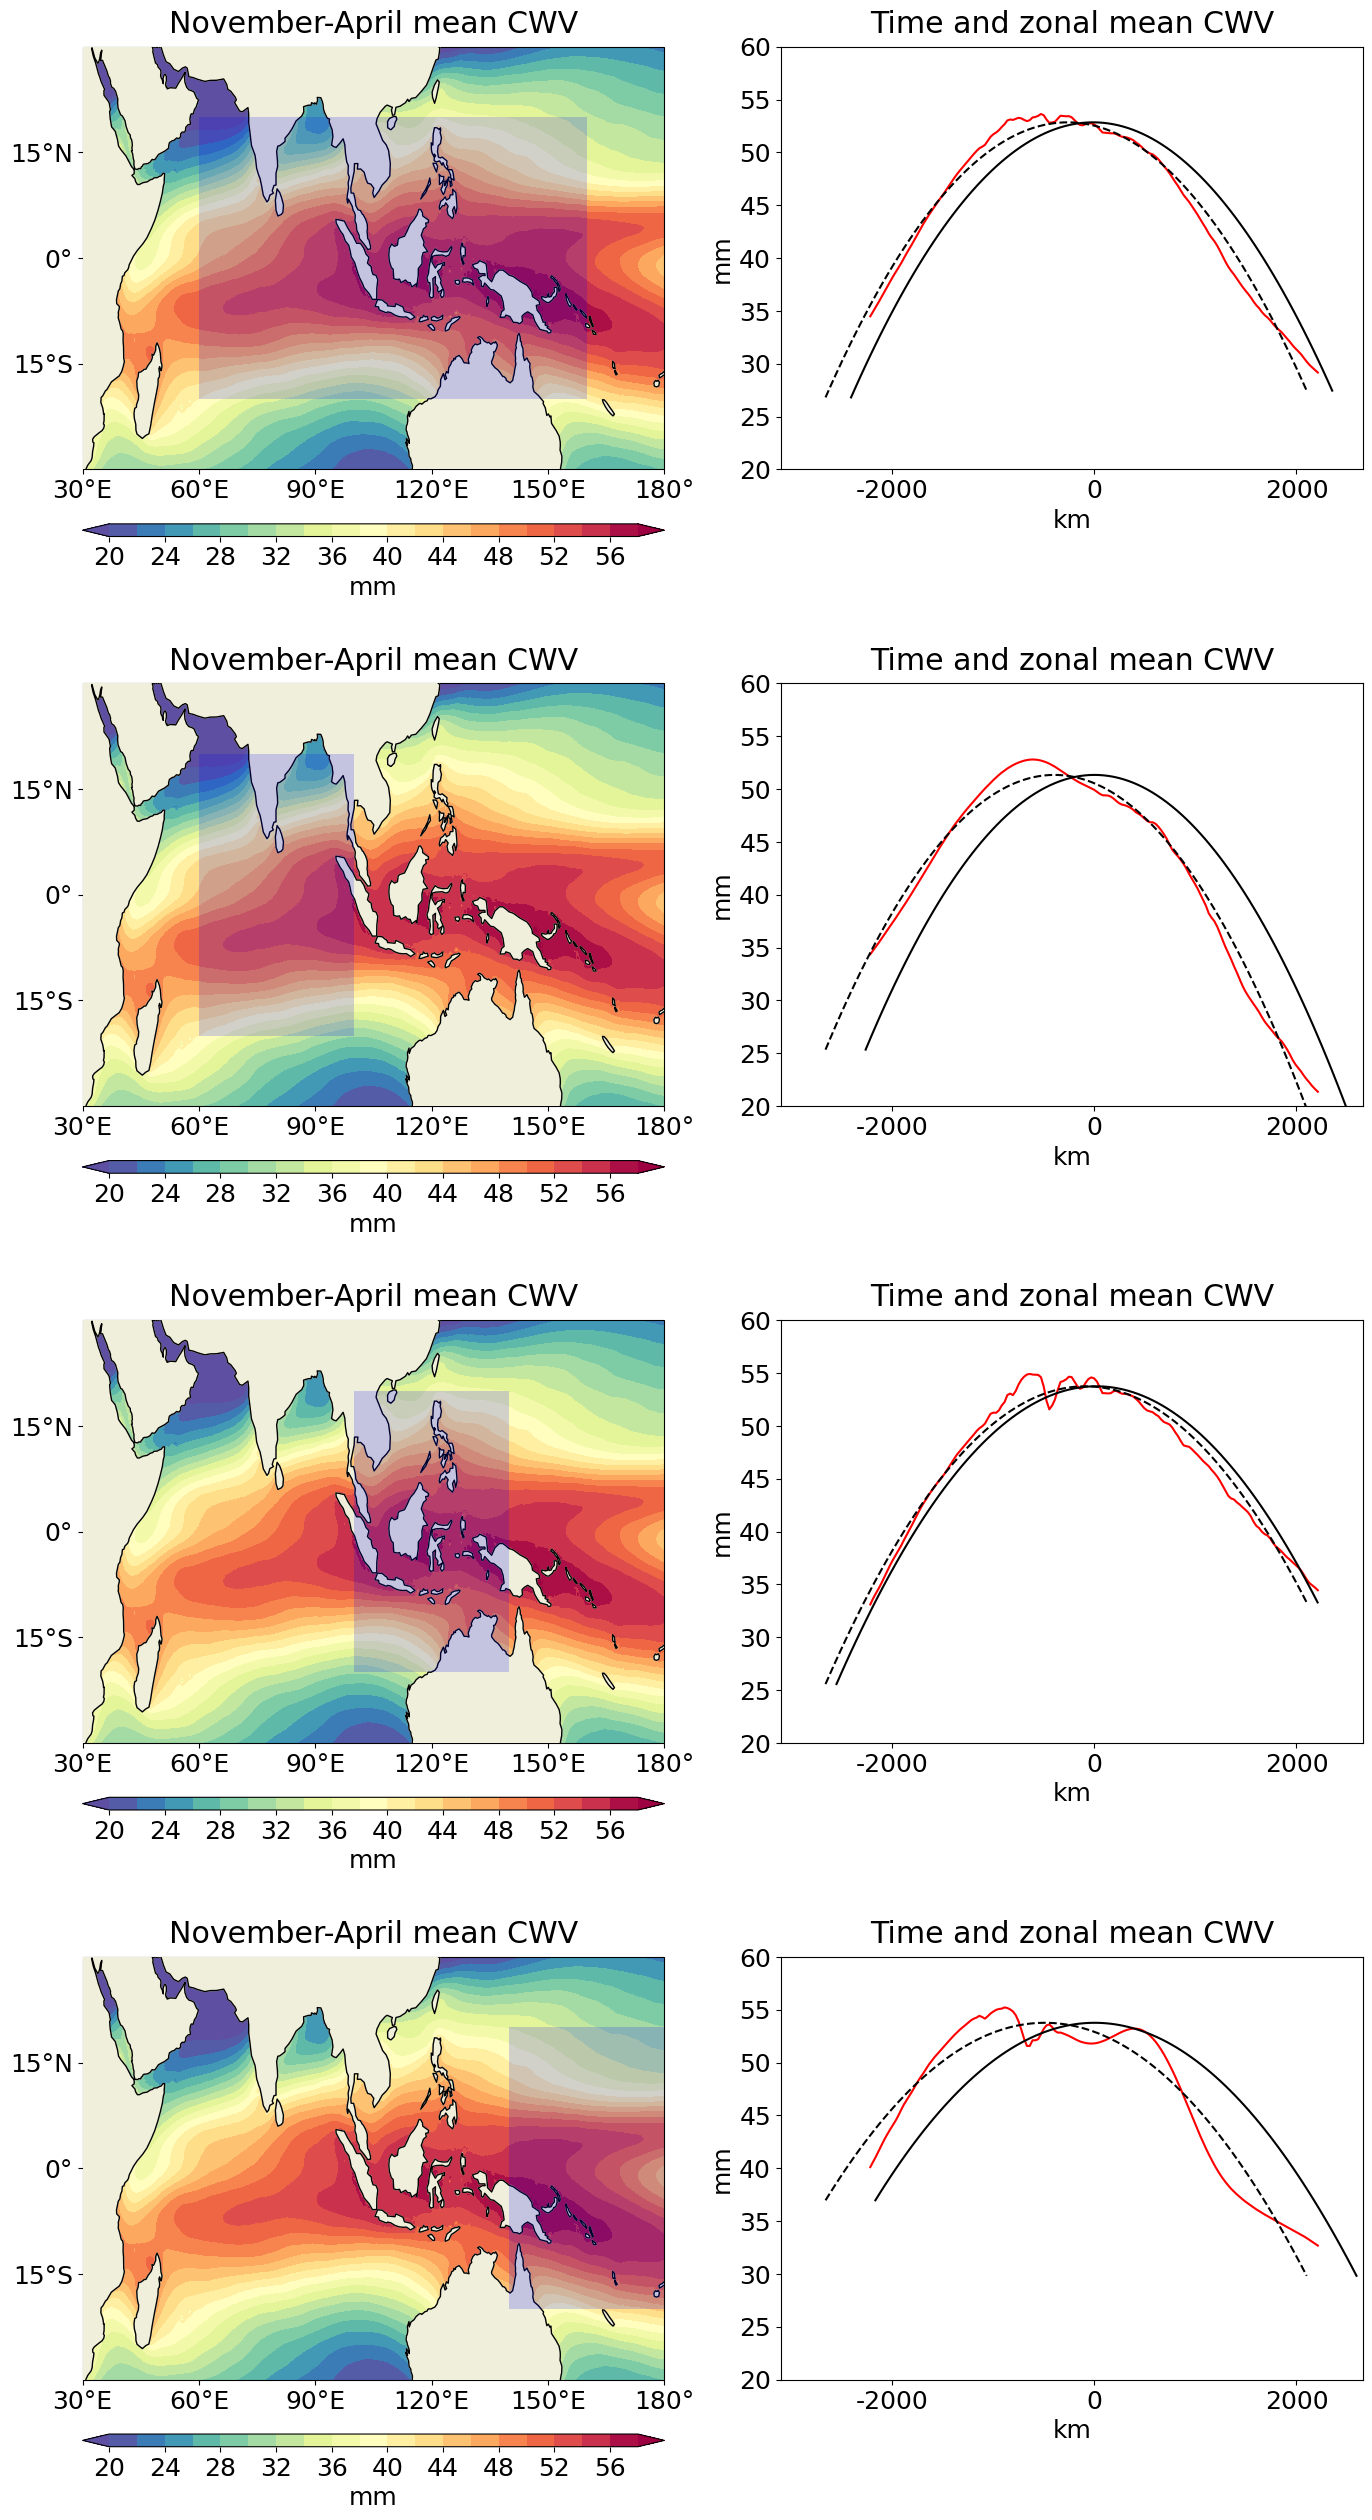

In [13]:
plt.style.use('default')
plt.rcParams.update({'font.size':18})
fig = plt.figure(figsize=(16,30))
gs = GridSpec(4,2, figure=fig, width_ratios=[60,40], height_ratios = [1,1,1,1])
gs.update(left = 0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)

gs0 = GridSpecFromSubplotSpec(2,2, subplot_spec=gs[0, :], hspace=0.25, height_ratios=[100,3])
gs1 = GridSpecFromSubplotSpec(2,2, subplot_spec=gs[1, :], hspace=0.25, height_ratios=[100,3])
gs2 = GridSpecFromSubplotSpec(2,2, subplot_spec=gs[2, :], hspace=0.25, height_ratios=[100,3])
gs3 = GridSpecFromSubplotSpec(2,2, subplot_spec=gs[3, :], hspace=0.25, height_ratios=[100,3])

data_crs = ccrs.PlateCarree()
proj = ccrs.PlateCarree()

avg_lons = [60,160]
avg_lats = [-20,20]

time_zonal_mean_column_water_vapor = column_water_vapor.sel(
    latitude=slice(avg_lats[0],avg_lats[1]), 
    longitude=slice(avg_lons[0], avg_lons[1])
).mean(dim=['longitude','time'])

map_ax0 = fig.add_subplot(gs0[0,0], projection=proj)
cbar_ax0 = fig.add_subplot(gs0[1,0])
plot_ax0 = fig.add_subplot(gs0[0,1])

map_ax0.set_title('November-April mean CWV', pad=10)
cont = map_ax0.contourf(
    column_water_vapor.longitude,
    column_water_vapor.latitude,
    column_water_vapor.mean(dim='time'),
    transform=data_crs,
    cmap='Spectral_r',
    levels=np.arange(20,60,2),
    extend='both'
)

map_ax0.set_extent([30,180,-30,30], crs=proj)
map_ax0.set_aspect('auto')

cbar = fig.colorbar(cont, cax=cbar_ax0, orientation='horizontal')
cbar.set_label('mm')
cbar.set_ticks(np.arange(20,60,4))

map_ax0.set_xticks(np.arange(30,210,30), crs=proj)
map_ax0.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

map_ax0.set_yticks(np.arange(-15,30,15), crs=proj)
map_ax0.yaxis.set_major_formatter(LatitudeFormatter())

map_ax0.add_feature(cfeature.LAND, zorder=100)
map_ax0.add_feature(cfeature.COASTLINE, lw=1, zorder=101)

map_ax0.spines['left'].set_edgecolor('black')
map_ax0.spines['right'].set_edgecolor('black')
map_ax0.spines['top'].set_edgecolor('black')
map_ax0.spines['bottom'].set_edgecolor('black')

rectangle = mpatches.Rectangle(
    (avg_lons[0], avg_lats[0]),
    avg_lons[1] - avg_lons[0],
    avg_lats[1]-avg_lats[0],
    facecolor='blue',
    alpha=0.175,
    zorder=102,
    transform=data_crs
)
map_ax0.add_patch(rectangle)

# Time and zonal mean CWV 
evaluation_points = np.linspace(-24, 19, 100)
parabolic_fit_coefficients = np.polyfit(
        time_zonal_mean_column_water_vapor.latitude,
        time_zonal_mean_column_water_vapor,
        2,
    )

# Evaluate the parabolic fit on the chosen domain
parabolic_fit = np.polyval(
        parabolic_fit_coefficients, evaluation_points
    )


plot_ax0.set_title('Time and zonal mean CWV', pad=10)
plot_ax0.plot(
    time_zonal_mean_column_water_vapor.latitude,
    time_zonal_mean_column_water_vapor,
    color='red',
    label='ERA5'
)

plot_ax0.plot(
    evaluation_points,
    parabolic_fit,
    color='black',
    ls='--',
    label='Shifted'
)

plot_ax0.plot(
    evaluation_points-evaluation_points[np.argmax(parabolic_fit)],
    parabolic_fit,
    color='black',
    label='Idealized'
)

plot_ax0.set_ylim(20,60)
plot_ax0.set_ylabel('mm')

plot_ax0.set_xlim(-28, 24)
plot_ax0.set_xticks([-2000*(1000/METERS_PER_DEGREE), 0, 2000*(1000/METERS_PER_DEGREE)])
plot_ax0.set_xticklabels([-2000, 0, 2000])
plot_ax0.set_xlabel('km')

plot_ax0.set_aspect('auto')



############## Indian Ocean ###################
avg_lons = [60,100]
avg_lats = [-20,20]

time_zonal_mean_column_water_vapor = column_water_vapor.sel(
    latitude=slice(avg_lats[0],avg_lats[1]), 
    longitude=slice(avg_lons[0], avg_lons[1])
).mean(dim=['longitude','time'])

map_ax1 = fig.add_subplot(gs1[0,0], projection=proj)
cbar_ax1 = fig.add_subplot(gs1[1,0])
plot_ax1 = fig.add_subplot(gs1[0,1])

map_ax1.set_title('November-April mean CWV', pad=10)
cont = map_ax1.contourf(
    column_water_vapor.longitude,
    column_water_vapor.latitude,
    column_water_vapor.mean(dim='time'),
    transform=data_crs,
    cmap='Spectral_r',
    levels=np.arange(20,60,2),
    extend='both'
)

map_ax1.set_extent([30,180,-30,30], crs=proj)
map_ax1.set_aspect('auto')

cbar = fig.colorbar(cont, cax=cbar_ax1, orientation='horizontal')
cbar.set_label('mm')
cbar.set_ticks(np.arange(20,60,4))

map_ax1.set_xticks(np.arange(30,210,30), crs=proj)
map_ax1.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

map_ax1.set_yticks(np.arange(-15,30,15), crs=proj)
map_ax1.yaxis.set_major_formatter(LatitudeFormatter())

map_ax1.add_feature(cfeature.LAND, zorder=100)
map_ax1.add_feature(cfeature.COASTLINE, lw=1, zorder=101)

map_ax1.spines['left'].set_edgecolor('black')
map_ax1.spines['right'].set_edgecolor('black')
map_ax1.spines['top'].set_edgecolor('black')
map_ax1.spines['bottom'].set_edgecolor('black')

rectangle = mpatches.Rectangle(
    (avg_lons[0], avg_lats[0]),
    avg_lons[1] - avg_lons[0],
    avg_lats[1]-avg_lats[0],
    facecolor='blue',
    alpha=0.175,
    zorder=102,
    transform=data_crs
)
map_ax1.add_patch(rectangle)

# Time and zonal mean CWV 
evaluation_points = np.linspace(-24, 19, 100)
parabolic_fit_coefficients = np.polyfit(
        time_zonal_mean_column_water_vapor.latitude,
        time_zonal_mean_column_water_vapor,
        2,
    )

# Evaluate the parabolic fit on the chosen domain
parabolic_fit = np.polyval(
        parabolic_fit_coefficients, evaluation_points
    )


plot_ax1.set_title('Time and zonal mean CWV', pad=10)
plot_ax1.plot(
    time_zonal_mean_column_water_vapor.latitude,
    time_zonal_mean_column_water_vapor,
    color='red',
    label='ERA5'
)

plot_ax1.plot(
    evaluation_points,
    parabolic_fit,
    color='black',
    ls='--',
    label='Shifted'
)

plot_ax1.plot(
    evaluation_points-evaluation_points[np.argmax(parabolic_fit)],
    parabolic_fit,
    color='black',
    label='Idealized'
)

plot_ax1.set_ylim(20,60)
plot_ax1.set_ylabel('mm')

plot_ax1.set_xlim(-28, 24)
plot_ax1.set_xticks([-2000*(1000/METERS_PER_DEGREE), 0, 2000*(1000/METERS_PER_DEGREE)])
plot_ax1.set_xticklabels([-2000, 0, 2000])
plot_ax1.set_xlabel('km')

plot_ax1.set_aspect('auto')


############### Maritime Continent ###################
avg_lons = [100,140]
avg_lats = [-20,20]

time_zonal_mean_column_water_vapor = column_water_vapor.sel(
    latitude=slice(avg_lats[0],avg_lats[1]), 
    longitude=slice(avg_lons[0], avg_lons[1])
).mean(dim=['longitude','time'])

map_ax2 = fig.add_subplot(gs2[0,0], projection=proj)
cbar_ax2 = fig.add_subplot(gs2[1,0])
plot_ax2 = fig.add_subplot(gs2[0,1])

map_ax2.set_title('November-April mean CWV', pad=10)
cont = map_ax2.contourf(
    column_water_vapor.longitude,
    column_water_vapor.latitude,
    column_water_vapor.mean(dim='time'),
    transform=data_crs,
    cmap='Spectral_r',
    levels=np.arange(20,60,2),
    extend='both'
)

map_ax2.set_extent([30,180,-30,30], crs=proj)
map_ax2.set_aspect('auto')

cbar = fig.colorbar(cont, cax=cbar_ax2, orientation='horizontal')
cbar.set_label('mm')
cbar.set_ticks(np.arange(20,60,4))

map_ax2.set_xticks(np.arange(30,210,30), crs=proj)
map_ax2.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

map_ax2.set_yticks(np.arange(-15,30,15), crs=proj)
map_ax2.yaxis.set_major_formatter(LatitudeFormatter())

map_ax2.add_feature(cfeature.LAND, zorder=100)
map_ax2.add_feature(cfeature.COASTLINE, lw=1, zorder=101)

map_ax2.spines['left'].set_edgecolor('black')
map_ax2.spines['right'].set_edgecolor('black')
map_ax2.spines['top'].set_edgecolor('black')
map_ax2.spines['bottom'].set_edgecolor('black')

rectangle = mpatches.Rectangle(
    (avg_lons[0], avg_lats[0]),
    avg_lons[1] - avg_lons[0],
    avg_lats[1]-avg_lats[0],
    facecolor='blue',
    alpha=0.175,
    zorder=102,
    transform=data_crs
)
map_ax2.add_patch(rectangle)

# Time and zonal mean CWV 
evaluation_points = np.linspace(-24, 19, 100)
parabolic_fit_coefficients = np.polyfit(
        time_zonal_mean_column_water_vapor.latitude,
        time_zonal_mean_column_water_vapor,
        2,
    )

# Evaluate the parabolic fit on the chosen domain
parabolic_fit = np.polyval(
        parabolic_fit_coefficients, evaluation_points
    )


plot_ax2.set_title('Time and zonal mean CWV', pad=10)
plot_ax2.plot(
    time_zonal_mean_column_water_vapor.latitude,
    time_zonal_mean_column_water_vapor,
    color='red',
    label='ERA5'
)

plot_ax2.plot(
    evaluation_points,
    parabolic_fit,
    color='black',
    ls='--',
    label='Shifted'
)

plot_ax2.plot(
    evaluation_points-evaluation_points[np.argmax(parabolic_fit)],
    parabolic_fit,
    color='black',
    label='Idealized'
)

plot_ax2.set_ylim(20,60)
plot_ax2.set_ylabel('mm')

plot_ax2.set_xlim(-28, 24)
plot_ax2.set_xticks([-2000*(1000/METERS_PER_DEGREE), 0, 2000*(1000/METERS_PER_DEGREE)])
plot_ax2.set_xticklabels([-2000, 0, 2000])
plot_ax2.set_xlabel('km')

plot_ax2.set_aspect('auto')

######################## Western Pacific #########################
avg_lons = [140,180]
avg_lats = [-20,20]

time_zonal_mean_column_water_vapor = column_water_vapor.sel(
    latitude=slice(avg_lats[0],avg_lats[1]), 
    longitude=slice(avg_lons[0], avg_lons[1])
).mean(dim=['longitude','time'])

map_ax3 = fig.add_subplot(gs3[0,0], projection=proj)
cbar_ax3 = fig.add_subplot(gs3[1,0])
plot_ax3 = fig.add_subplot(gs3[0,1])

map_ax3.set_title('November-April mean CWV', pad=10)
cont = map_ax3.contourf(
    column_water_vapor.longitude,
    column_water_vapor.latitude,
    column_water_vapor.mean(dim='time'),
    transform=data_crs,
    cmap='Spectral_r',
    levels=np.arange(20,60,2),
    extend='both'
)

map_ax3.set_extent([30,180,-30,30], crs=proj)
map_ax3.set_aspect('auto')

cbar = fig.colorbar(cont, cax=cbar_ax3, orientation='horizontal')
cbar.set_label('mm')
cbar.set_ticks(np.arange(20,60,4))

map_ax3.set_xticks(np.arange(30,210,30), crs=proj)
map_ax3.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

map_ax3.set_yticks(np.arange(-15,30,15), crs=proj)
map_ax3.yaxis.set_major_formatter(LatitudeFormatter())

map_ax3.add_feature(cfeature.LAND, zorder=100)
map_ax3.add_feature(cfeature.COASTLINE, lw=1, zorder=101)

map_ax3.spines['left'].set_edgecolor('black')
map_ax3.spines['right'].set_edgecolor('black')
map_ax3.spines['top'].set_edgecolor('black')
map_ax3.spines['bottom'].set_edgecolor('black')

rectangle = mpatches.Rectangle(
    (avg_lons[0], avg_lats[0]),
    avg_lons[1] - avg_lons[0],
    avg_lats[1]-avg_lats[0],
    facecolor='blue',
    alpha=0.175,
    zorder=102,
    transform=data_crs
)
map_ax3.add_patch(rectangle)

# Time and zonal mean CWV 
evaluation_points = np.linspace(-24, 19, 100)
parabolic_fit_coefficients = np.polyfit(
        time_zonal_mean_column_water_vapor.latitude,
        time_zonal_mean_column_water_vapor,
        2,
    )

# Evaluate the parabolic fit on the chosen domain
parabolic_fit = np.polyval(
        parabolic_fit_coefficients, evaluation_points
    )


plot_ax3.set_title('Time and zonal mean CWV', pad=10)
plot_ax3.plot(
    time_zonal_mean_column_water_vapor.latitude,
    time_zonal_mean_column_water_vapor,
    color='red',
    label='ERA5'
)

plot_ax3.plot(
    evaluation_points,
    parabolic_fit,
    color='black',
    ls='--',
    label='Shifted'
)

plot_ax3.plot(
    evaluation_points-evaluation_points[np.argmax(parabolic_fit)],
    parabolic_fit,
    color='black',
    label='Idealized'
)

plot_ax3.set_ylim(20,60)
plot_ax3.set_ylabel('mm')

plot_ax3.set_xlim(-28, 24)
plot_ax3.set_xticks([-2000*(1000/METERS_PER_DEGREE), 0, 2000*(1000/METERS_PER_DEGREE)])
plot_ax3.set_xticklabels([-2000, 0, 2000])
plot_ax3.set_xlabel('km')

plot_ax3.set_aspect('auto')
plt.savefig(f"{output_directory}{Ahmed21}/Ahmed21_Fig1_modified_combined.png", dpi=300, bbox_inches='tight')

# Symmetry Analysis

(0.0, 20.0)

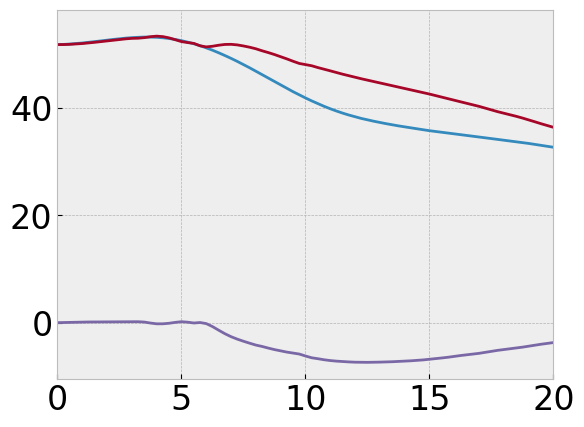

In [173]:
plt.plot(time_zonal_mean_column_water_vapor.latitude, time_zonal_mean_column_water_vapor.values)

sym_component = (time_zonal_mean_column_water_vapor.values + time_zonal_mean_column_water_vapor[::-1].values)/2
asym_component = (time_zonal_mean_column_water_vapor.values - time_zonal_mean_column_water_vapor[::-1].values)/2

plt.plot(time_zonal_mean_column_water_vapor.latitude, 
         sym_component
        )
plt.plot(time_zonal_mean_column_water_vapor.latitude, 
         asym_component
        )

plt.xlim(0,20)

## Stacked bar chart

(0.0, 20.0)

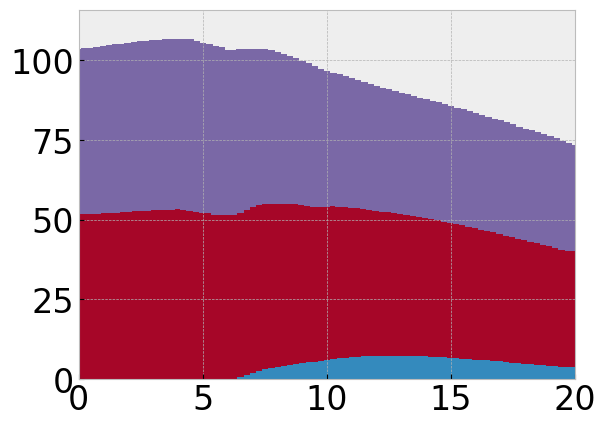

In [176]:
fig, ax = plt.subplots()

# Plot the stacked bars
ax.bar(time_zonal_mean_column_water_vapor.latitude, np.abs(asym_component), label='Data 1')
ax.bar(time_zonal_mean_column_water_vapor.latitude, np.abs(sym_component), bottom=np.abs(asym_component), label='Data 2')
ax.bar(time_zonal_mean_column_water_vapor.latitude, time_zonal_mean_column_water_vapor, bottom=np.abs(sym_component) + np.abs(asym_component), label='Data 3')

ax.set_xlim(0,20)
plt.show()

# Symmetric & Anti-symmetric

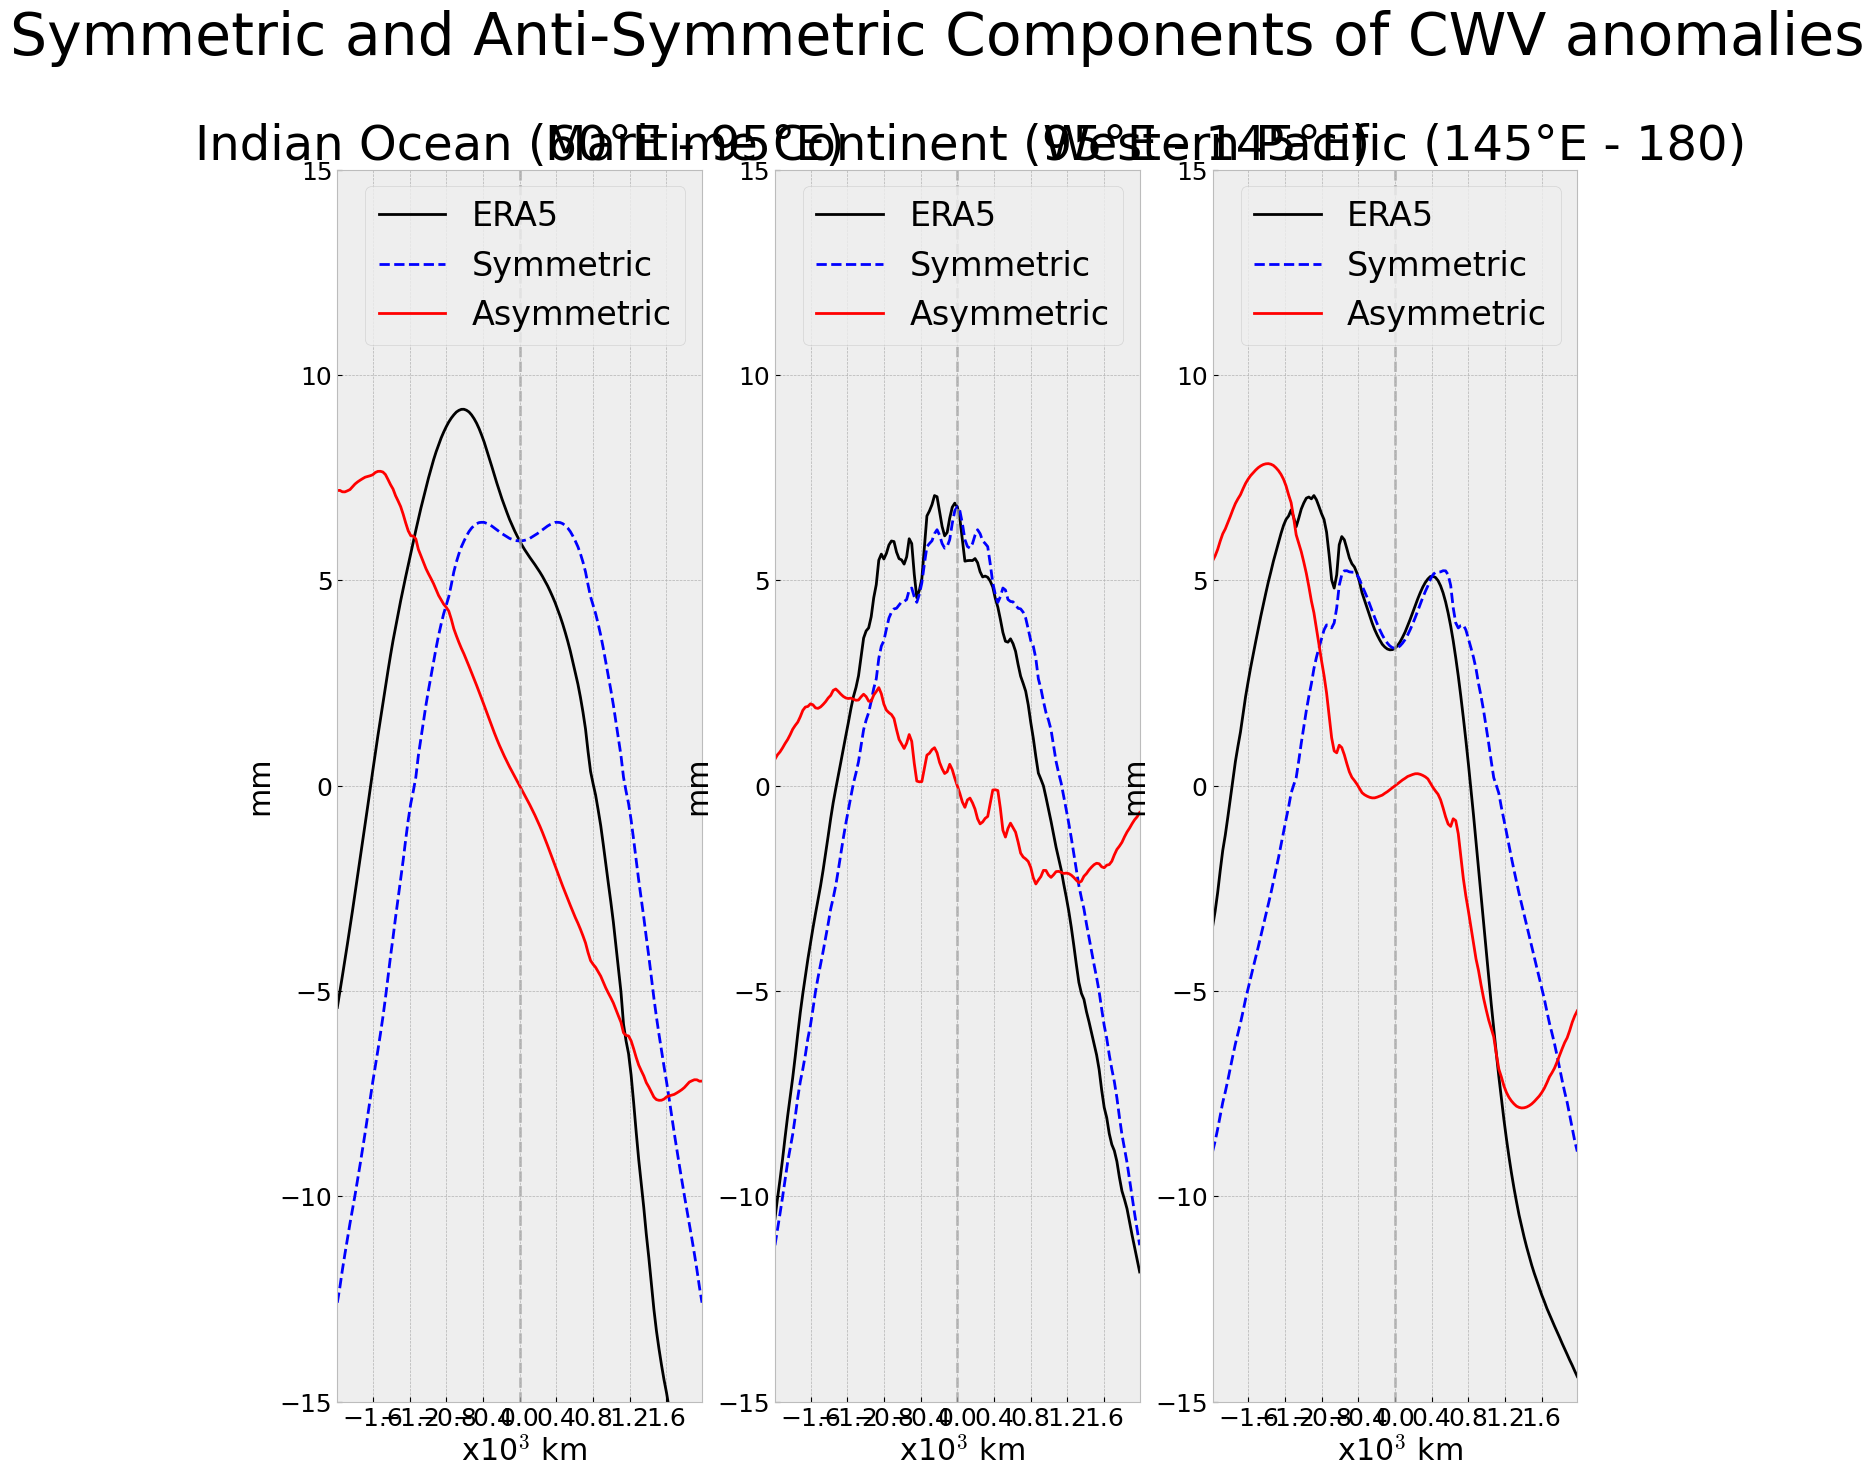

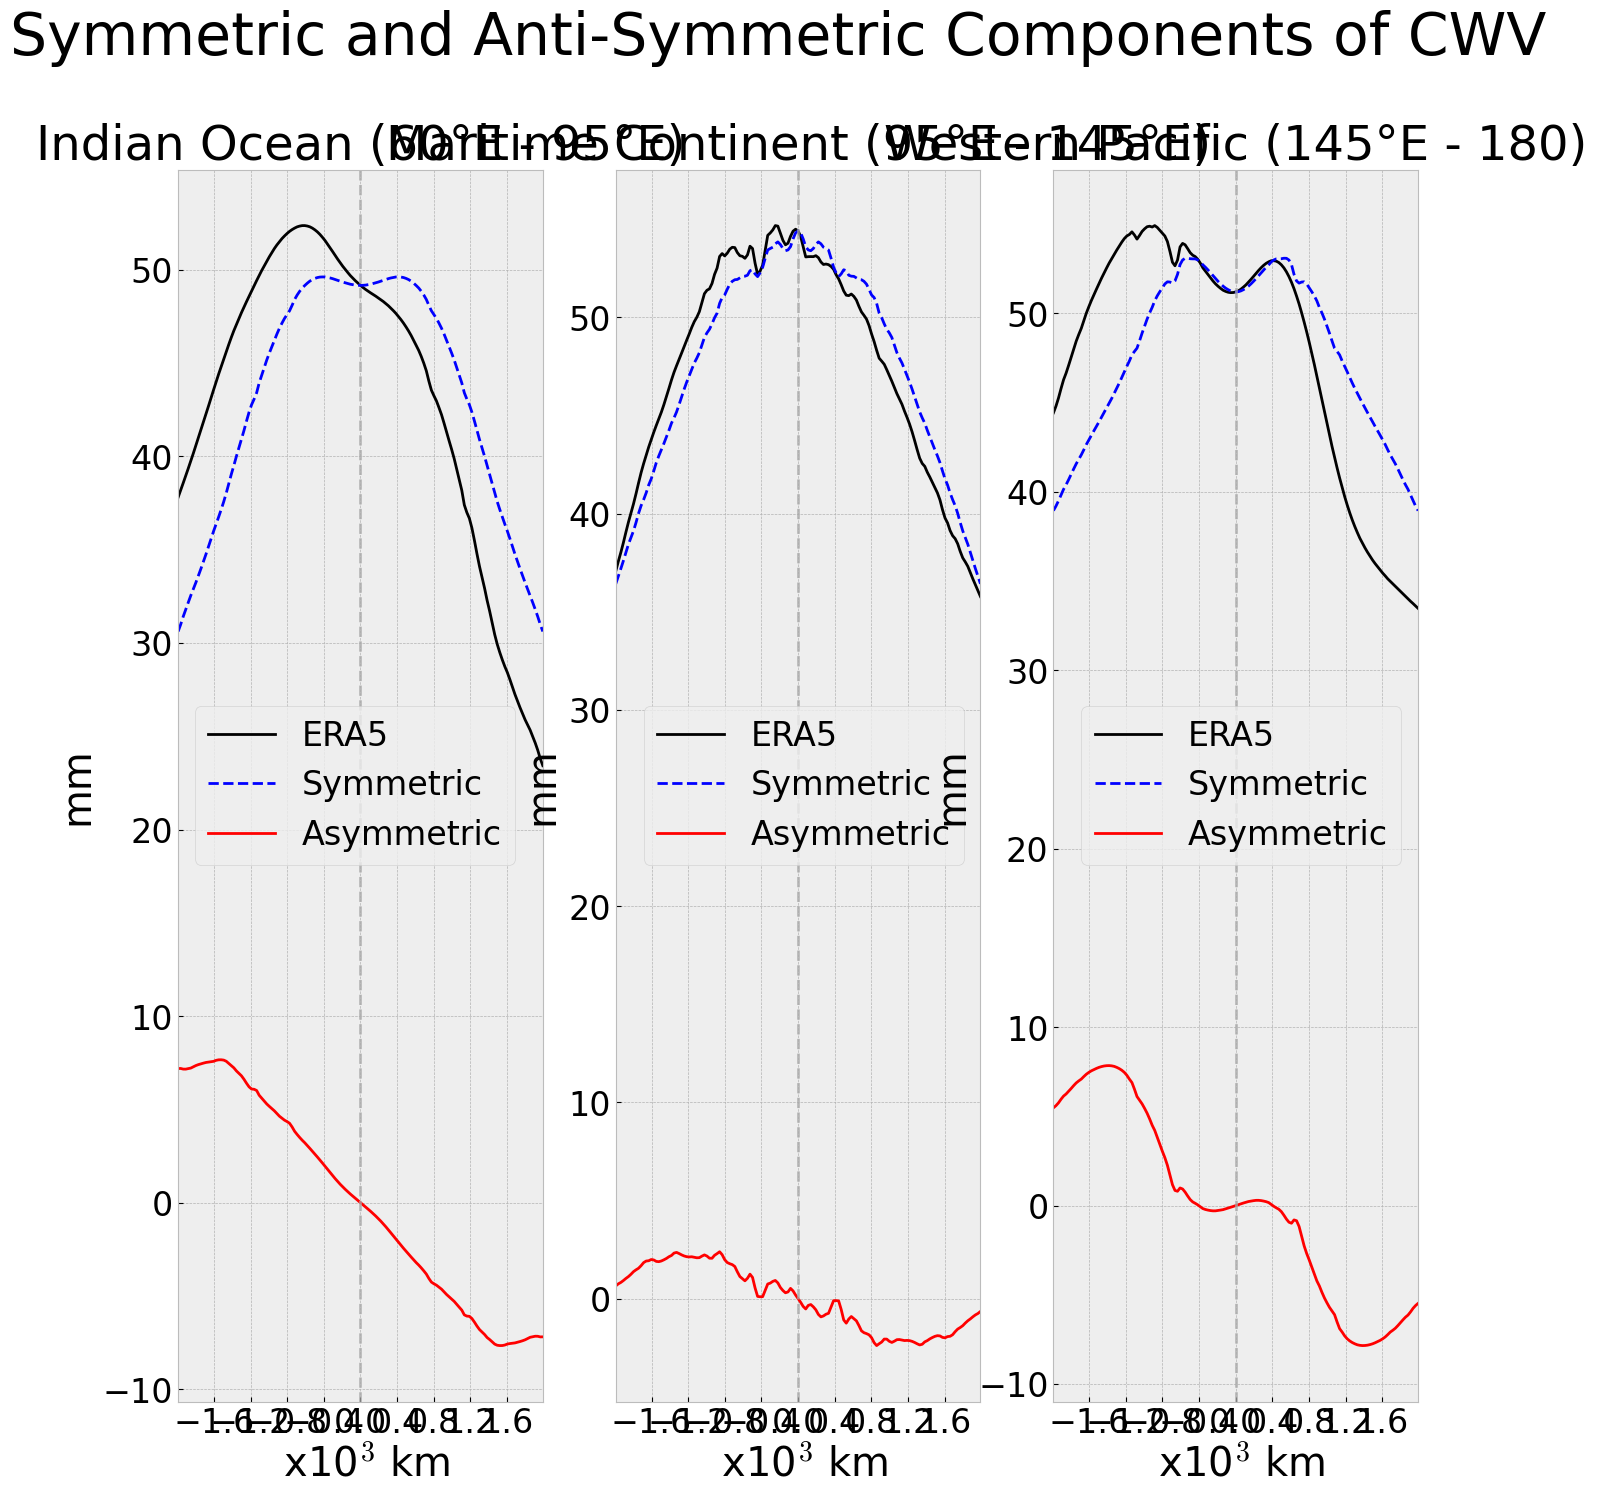

In [153]:
#%% Symmetric and Antisymmetric Anomalies

latitude_size = int(len(latitude_tropics))
latitude_size_half = int((len(latitude_tropics) + 1) / 2)

zonal_time_mean_column_water_vapor_anomalies = {}
for _, key in enumerate(zonal_time_mean_column_water_vapor):
    zonal_time_mean_column_water_vapor_anomalies[
        key
    ] = zonal_time_mean_column_water_vapor[key] - zonal_time_mean_column_water_vapor[
        key
    ].mean(
        dim="latitude"
    )
sym_zonal_time_mean_column_water_vapor_anomalies = {}
sym_zonal_time_mean_column_water_vapor_anomalies["Indian Ocean"] = np.empty(
    (latitude_size)
)
sym_zonal_time_mean_column_water_vapor_anomalies["Maritime Continent"] = np.empty(
    (latitude_size)
)
sym_zonal_time_mean_column_water_vapor_anomalies["Western Pacific"] = np.empty(
    (latitude_size)
)

asym_zonal_time_mean_column_water_vapor_anomalies = {}
asym_zonal_time_mean_column_water_vapor_anomalies["Indian Ocean"] = np.empty(
    (latitude_size)
)
asym_zonal_time_mean_column_water_vapor_anomalies["Maritime Continent"] = np.empty(
    (latitude_size)
)
asym_zonal_time_mean_column_water_vapor_anomalies["Western Pacific"] = np.empty(
    (latitude_size)
)


for _, key in enumerate(sym_zonal_time_mean_column_water_vapor_anomalies):
    for i in range(0, latitude_size_half):
        # Symmetric Component - NH
        sym_zonal_time_mean_column_water_vapor_anomalies[key][i] = (
            zonal_time_mean_column_water_vapor_anomalies[key][i]
            + zonal_time_mean_column_water_vapor_anomalies[key][latitude_size - i - 1]
        ) / 2

        # SH
        sym_zonal_time_mean_column_water_vapor_anomalies[key][latitude_size - i - 1] = (
            zonal_time_mean_column_water_vapor_anomalies[key][i]
            + zonal_time_mean_column_water_vapor_anomalies[key][latitude_size - i - 1]
        ) / 2

        # Antisymmetric Component - NH
        asym_zonal_time_mean_column_water_vapor_anomalies[key][i] = (
            zonal_time_mean_column_water_vapor_anomalies[key][i]
            - zonal_time_mean_column_water_vapor_anomalies[key][latitude_size - i - 1]
        ) / 2

        # SH
        asym_zonal_time_mean_column_water_vapor_anomalies[key][
            latitude_size - i - 1
        ] = -(
            (
                zonal_time_mean_column_water_vapor_anomalies[key][i]
                - zonal_time_mean_column_water_vapor_anomalies[key][
                    latitude_size - i - 1
                ]
            )
            / 2
        )
plt.style.use("bmh")
[fig, ax] = plt.subplots(1, 3, figsize=(16, 16))
plt.rcParams.update({"font.size": 24})
plt.suptitle("Symmetric and Anti-Symmetric Components of CWV anomalies", fontsize=42)

regional_title = {}
regional_title["Indian Ocean"] = "Indian Ocean (60°E - 95°E)"
regional_title["Maritime Continent"] = "Maritime Continent (95°E - 145°E)"
regional_title["Western Pacific"] = "Western Pacific (145°E - 180)"

for i, key in enumerate(sym_zonal_time_mean_column_water_vapor_anomalies):
    ax[i].set_title(regional_title[key])
    ax[i].set_xlabel(r" x10$^{3}$ km")
    ax[i].set_ylabel("mm")

    # Raw data
    ax[i].plot(
        meridional_distance / scale,
        zonal_time_mean_column_water_vapor_anomalies[key],
        label="ERA5",
        color="black",
    )

    # Symmetric component
    ax[i].plot(
        meridional_distance / scale,
        sym_zonal_time_mean_column_water_vapor_anomalies[key],
        label="Symmetric",
        color="blue",
        ls="--",
    )

    # Anti-symmetric component
    ax[i].plot(
        meridional_distance / scale,
        asym_zonal_time_mean_column_water_vapor_anomalies[key],
        label="Asymmetric",
        color="red",
        ls="-",
    )

    ax[i].legend()
    ax[i].set_xlim(meridional_distance[0] / scale, meridional_distance[-1] / scale)
    ax[i].set_ylim(-15, 15)
    ax[i].axvline(x=0, color="darkgray", ls="--", lw=2, alpha=0.75)
    ax[i].xaxis.set_major_locator(MaxNLocator(prune="lower"))
#%% Symmetric and Antisymmetric
# Symmetric and Antisymmetric components

latitude_size = int(len(latitude_tropics))
latitude_size_half = int((len(latitude_tropics) + 1) / 2)

sym_zonal_time_mean_column_water_vapor = {}
sym_zonal_time_mean_column_water_vapor["Indian Ocean"] = np.empty((latitude_size))
sym_zonal_time_mean_column_water_vapor["Maritime Continent"] = np.empty((latitude_size))
sym_zonal_time_mean_column_water_vapor["Western Pacific"] = np.empty((latitude_size))

asym_zonal_time_mean_column_water_vapor = {}
asym_zonal_time_mean_column_water_vapor["Indian Ocean"] = np.empty((latitude_size))
asym_zonal_time_mean_column_water_vapor["Maritime Continent"] = np.empty(
    (latitude_size)
)
asym_zonal_time_mean_column_water_vapor["Western Pacific"] = np.empty((latitude_size))


for _, key in enumerate(sym_zonal_time_mean_column_water_vapor):
    for i in range(0, latitude_size_half):
        # Symmetric Component - NH
        sym_zonal_time_mean_column_water_vapor[key][i] = (
            zonal_time_mean_column_water_vapor[key][i]
            + zonal_time_mean_column_water_vapor[key][latitude_size - i - 1]
        ) / 2

        # SH
        sym_zonal_time_mean_column_water_vapor[key][latitude_size - i - 1] = (
            zonal_time_mean_column_water_vapor[key][i]
            + zonal_time_mean_column_water_vapor[key][latitude_size - i - 1]
        ) / 2

        # Antisymmetric Component - NH
        asym_zonal_time_mean_column_water_vapor[key][i] = (
            zonal_time_mean_column_water_vapor[key][i]
            - zonal_time_mean_column_water_vapor[key][latitude_size - i - 1]
        ) / 2

        # SH
        asym_zonal_time_mean_column_water_vapor[key][latitude_size - i - 1] = -(
            (
                zonal_time_mean_column_water_vapor[key][i]
                - zonal_time_mean_column_water_vapor[key][latitude_size - i - 1]
            )
            / 2
        )
plt.style.use("bmh")
[fig, ax] = plt.subplots(1, 3, figsize=(16, 16))
plt.rcParams.update({"font.size": 24})
plt.suptitle("Symmetric and Anti-Symmetric Components of CWV", fontsize=42)

regional_title = {}
regional_title["Indian Ocean"] = "Indian Ocean (60°E - 95°E)"
regional_title["Maritime Continent"] = "Maritime Continent (95°E - 145°E)"
regional_title["Western Pacific"] = "Western Pacific (145°E - 180)"

for i, key in enumerate(sym_zonal_time_mean_column_water_vapor):
    ax[i].set_title(regional_title[key])
    ax[i].set_xlabel(r" x10$^{3}$ km")
    ax[i].set_ylabel("mm")

    # Raw data
    ax[i].plot(
        meridional_distance / scale,
        zonal_time_mean_column_water_vapor[key],
        label="ERA5",
        color="black",
    )

    # Symmetric component
    ax[i].plot(
        meridional_distance / scale,
        sym_zonal_time_mean_column_water_vapor[key],
        label="Symmetric",
        color="blue",
        ls="--",
    )

    # Anti-symmetric component
    ax[i].plot(
        meridional_distance / scale,
        asym_zonal_time_mean_column_water_vapor[key],
        label="Asymmetric",
        color="red",
        ls="-",
    )

    ax[i].legend()
    ax[i].set_xlim(meridional_distance[0] / scale, meridional_distance[-1] / scale)
    ax[i].axvline(x=0, color="darkgray", ls="--", lw=2, alpha=0.75)
    ax[i].xaxis.set_major_locator(MaxNLocator(prune="lower"))
